In [1]:
cd ..

/experiments_motion


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
sys.path.append('./Motion')
sys.path.append('./compare/DLow')

In [4]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import yaml
from tqdm import tqdm
from IPython.display import display, HTML

In [5]:
from motion import Motion
from motion import Quaternion
from h36m.skeleton import H36MSkeleton
from h36m.dataset.h36m_torch_dataset import H36MTorchDataset
from h36m.dataset.h36m_dataset import H36MDataset
from h36m.dataset.h36m_test_dataset import H36MTestDataset
from helper.helper import add_static_nodes
from motion_pred.eval import *

In [6]:
from metrics import MeanAngleL2Error, MeanPerJointPositionError, NegativeLogLikelihood

# Load H3.6M Skeleton

In [7]:
# Load skeleton configuration
with open('./config/h36m_skeleton_gen.yaml', 'r') as stream:
    skeleton = H36MSkeleton(**yaml.safe_load(stream))

## Define Eval Metrics

In [8]:
mae_l2_metric = MeanAngleL2Error(ignore_root=True) # We ignore the root rotation in the world for the origin joint
mpjpe_metric = MeanPerJointPositionError()
nll_metric = NegativeLogLikelihood()

In [9]:
t = [0.08, 0.16, 0.32, 0.4, 0.56, 0.72, 0.88, 1.]

## Load the Model

In [10]:
MODEL_PATH = './output/h36m/generative/'
CHECKPOINT = 'model'
CHECKPOINT_PATH = os.path.join(MODEL_PATH, CHECKPOINT + '.pth.tar')

In [11]:
# Load model config
with open(os.path.join(MODEL_PATH, 'config.yaml'), 'r') as file:
    model_config = yaml.safe_load(file)

In [12]:
model = Motion(skeleton, T=skeleton.nodes_type_id_dynamic, **model_config)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu')))
model.eval()
print('Model Loaded')

Model Loaded


In [13]:
from scipy.stats import gaussian_kde
def compute_kde_nll(y, y_pred):
    bs, sp, ts, ns, d = y_pred.shape
    kde_ll = torch.zeros((bs, ts, ns))

    for b in range(bs):
        for t in range(ts):
            for n in range(ns):
                try:
                    kde = gaussian_kde(y_pred[b, :, t, n].T)
                    pdf = kde.logpdf(y[b, t, n].T)
                    kde_ll[b, t, n] = torch.tensor(pdf)
                except np.linalg.LinAlgError:
                    print(b, t, n)
                    print('nan')
                    pass

    return -kde_ll

## Load Evaluation Data

In [14]:
DATA_PATH = './data/processed/h3.6m.npz'

In [15]:
h36m_dataset = H36MDataset(DATA_PATH, dataset_fps=50, dataset_downsample_factor=1)

In [16]:
def skeleton_set(skeleton, s):
    jl = []
    for i, p in enumerate(skeleton._parents):
        if p > -1:
            jl.append((s[i] - s[p]) * 1000.)
    l = torch.tensor(np.linalg.norm(np.array(jl), axis=-1))
    skeleton._offsets[skeleton._offsets.abs() > 0.] = l[l.abs() > 0.] * torch.sign(skeleton._offsets[skeleton._offsets.abs() > 0.])

In [17]:
d = np.load('./compare/DLow/data/data_3d_h36m.npz', allow_pickle=True)
pos = d['positions_3d'].item()

In [18]:
ph = 100

In [19]:
dataset_eval_9 = H36MTorchDataset(h36m_dataset,
                                subjects=['S9'],
                                history_length=25,
                                prediction_horizon=ph,
                                step=25)
data_loader_eval = DataLoader(dataset_eval_9, shuffle=False, batch_size=20)
skeleton_set(skeleton, pos['S9']['Phoning'][100])

In [20]:
removed_joints = {0, 4, 5, 9, 10, 11, 16, 20, 21, 22, 23, 24, 28, 29, 30, 31}
kept_joints = np.array([x for x in range(32) if x not in removed_joints])

In [21]:
nll_list = []

In [22]:
n_samp = 1000
with torch.no_grad():
    for x, y in tqdm(data_loader_eval):
        # Remove static nodes
        x_dynamic = Quaternion.qfix_positive_(x[:, :, skeleton.dynamic_nodes])

        # Run Model 
        p_q, _, _, _ = model(x_dynamic, None, ph=ph)

        # The mode of the Distribution are the rotations
        q_samp = p_q.sample((n_samp,))
        # Add static rotations q = [1., 0., 0., 0.]
        q_samp_all = add_static_nodes(q_samp, skeleton.static_nodes, skeleton.dynamic_nodes)
        q_samp_all = q_samp_all.permute(1, 0, 2, 3, 4).contiguous()
        
        pos_saml_all = skeleton(q_samp_all.view(-1, 32, 4), ignore_root=False).view(-1, n_samp, ph, 32, 3) / 1000.
        pos_saml_all = pos_saml_all[..., [0, 2, 1]] * torch.tensor([[[1., -1., 1.]]])
        pos_y = skeleton(y.view(-1, 32, 4), ignore_root=False).view(-1, ph, 32, 3) / 1000.
        pos_y = pos_y[..., [0, 2, 1]] * torch.tensor([[[1., -1., 1.]]])

        nll_list.append(compute_kde_nll(pos_y[..., kept_joints, :], pos_saml_all[..., kept_joints, :]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [2:36:08<00:00, 61.23s/it]


In [23]:
dataset_eval_11 = H36MTorchDataset(h36m_dataset,
                                subjects=['S11'],
                                history_length=25,
                                prediction_horizon=ph,
                                skip_11_d=True,
                                step=25)
data_loader_eval = DataLoader(dataset_eval_11, shuffle=False, batch_size=20)
skeleton_set(skeleton, pos['S11']['Phoning 2'][100])

In [24]:
n_samp = 1000
with torch.no_grad():
    for x, y in tqdm(data_loader_eval):
        y = y[:, :ph]
        # Remove static nodes
        x_dynamic = Quaternion.qfix_positive_(x[:, :, skeleton.dynamic_nodes])

        # Run Model 
        p_q, _, _, _ = model(x_dynamic, None, ph=ph)

        # The mode of the Distribution are the rotations
        q_samp = p_q.sample((n_samp,))
        # Add static rotations q = [1., 0., 0., 0.]
        q_samp_all = add_static_nodes(q_samp, skeleton.static_nodes, skeleton.dynamic_nodes)
        q_samp_all = q_samp_all.permute(1, 0, 2, 3, 4).contiguous()
        
        pos_saml_all = skeleton(q_samp_all.view(-1, 32, 4), ignore_root=False).view(-1, n_samp, ph, 32, 3) / 1000.
        pos_saml_all = pos_saml_all[..., [0, 2, 1]] * torch.tensor([[[1., -1., 1.]]])
        pos_y = skeleton(y.view(-1, 32, 4), ignore_root=False).view(-1, ph, 32, 3) / 1000.
        pos_y = pos_y[..., [0, 2, 1]] * torch.tensor([[[1., -1., 1.]]])

        nll_list.append(compute_kde_nll(pos_y[..., kept_joints, :], pos_saml_all[..., kept_joints, :]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [1:48:46<00:00, 61.00s/it]


In [25]:
nll = torch.cat(nll_list, dim=0)

In [26]:
nll.shape

torch.Size([5168, 100, 16])

In [27]:
nll.clip(max=20).sum(-1).mean(0)

tensor([-225.4230, -219.6264, -213.3682, -206.5681, -199.9201, -193.8234,
        -188.0764, -183.2545, -178.6342, -174.5607, -170.7909, -167.4265,
        -164.1727, -161.2912, -158.5014, -155.9699, -153.7534, -151.5397,
        -149.3174, -147.3510, -145.4922, -143.7001, -142.1263, -140.5972,
        -139.1247, -137.6799, -136.3465, -135.2609, -133.9920, -132.7111,
        -131.5819, -130.3897, -129.4291, -128.3610, -127.3568, -126.3026,
        -125.4522, -124.5719, -123.6919, -122.8751, -122.1060, -121.3581,
        -120.4761, -119.5919, -118.8676, -118.1999, -117.5881, -116.9597,
        -116.3734, -115.7075, -115.0430, -114.3552, -113.9391, -113.2986,
        -112.7864, -112.3216, -111.7343, -111.2165, -110.6406, -110.2042,
        -109.6375, -109.2118, -108.7496, -108.1491, -107.6687, -107.2041,
        -106.7663, -106.2627, -105.7939, -105.2628, -104.9077, -104.5189,
        -104.1635, -103.7919, -103.4356, -103.0065, -102.6123, -102.3383,
        -101.8389, -101.5814, -101.229

In [28]:
nll.sum(-1).mean(0)

tensor([-214.5984, -208.1160, -199.0680, -167.1066, -183.8944, -175.1492,
        -169.4911, -166.5029, -162.9499, -153.9155, -159.3693, -156.7440,
        -153.6215, -150.4130, -148.6889, -146.4549, -146.0190, -143.8381,
        -129.8577, -138.3621, -124.5780, -136.6858, -136.4832, -134.9216,
        -128.6812, -132.2304, -130.5939, -126.7591, -122.6389, -127.4625,
        -125.5627, -120.9751, -125.1916, -123.9899, -116.2621, -121.6524,
        -119.1794, -117.9510, -117.1451, -116.5562, -114.4542, -116.5043,
        -115.4271, -106.2266, -113.1922, -102.1479, -110.8377, -111.1752,
        -109.9623, -108.3451, -105.4791, -105.3250, -104.6029,  -96.7965,
        -103.1861, -101.7845,  -97.8379, -106.2903, -105.9496,  -96.3392,
        -102.2340,  -98.4339,  -97.1623,  -96.9791,  -98.0031,  -94.5512,
         -99.4137, -101.2198,  -95.9108, -101.6905,  -90.2884, -100.9414,
        -102.0880, -101.9720, -101.3736,  -98.7354, -101.7103, -103.3430,
        -102.3781, -102.6696, -101.673

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
our_nll = torch.tensor([-225.4230, -219.6264, -213.3682, -206.5681, -199.9201, -193.8234,
        -188.0764, -183.2545, -178.6342, -174.5607, -170.7909, -167.4265,
        -164.1727, -161.2912, -158.5014, -155.9699, -153.7534, -151.5397,
        -149.3174, -147.3510, -145.4922, -143.7001, -142.1263, -140.5972,
        -139.1247, -137.6799, -136.3465, -135.2609, -133.9920, -132.7111,
        -131.5819, -130.3897, -129.4291, -128.3610, -127.3568, -126.3026,
        -125.4522, -124.5719, -123.6919, -122.8751, -122.1060, -121.3581,
        -120.4761, -119.5919, -118.8676, -118.1999, -117.5881, -116.9597,
        -116.3734, -115.7075, -115.0430, -114.3552, -113.9391, -113.2986,
        -112.7864, -112.3216, -111.7343, -111.2165, -110.6406, -110.2042,
        -109.6375, -109.2118, -108.7496, -108.1491, -107.6687, -107.2041,
        -106.7663, -106.2627, -105.7939, -105.2628, -104.9077, -104.5189,
        -104.1635, -103.7919, -103.4356, -103.0065, -102.6123, -102.3383,
        -101.8389, -101.5814, -101.2291, -100.8088, -100.5858, -100.1535,
         -99.8183,  -99.5381,  -99.2446,  -98.9113,  -98.5526,  -98.2295,
         -97.9217,  -97.6139,  -97.2809,  -96.8623,  -96.5484,  -96.2781,
         -96.0728,  -95.8510,  -95.5227,  -95.2220])

In [4]:
dlow_nll = torch.tensor([115.6573,  53.8431, -12.9685, -51.4870, -69.4903, -78.1288, -82.5270,
        -84.7968, -85.8376, -86.4732, -86.9339, -87.1482, -87.2519, -87.2515,
        -87.2234, -87.0629, -86.8170, -86.5770, -86.1807, -85.7386, -85.3267,
        -84.9387, -84.5291, -84.0931, -83.6289, -83.1264, -82.6000, -82.0796,
        -81.4962, -80.8790, -80.2513, -79.6091, -79.0010, -78.3597, -77.7429,
        -77.1220, -76.4933, -75.9142, -75.3304, -74.7518, -74.1841, -73.6319,
        -73.0862, -72.5533, -72.0395, -71.5494, -71.0771, -70.6249, -70.1895,
        -69.7316, -69.2791, -68.8391, -68.3947, -67.9507, -67.5247, -67.1117,
        -66.6923, -66.2854, -65.8880, -65.5115, -65.1341, -64.7701, -64.4187,
        -64.0621, -63.7194, -63.3797, -63.0506, -62.7341, -62.4353, -62.1468,
        -61.8750, -61.6272, -61.3977, -61.1749, -60.9442, -60.7227, -60.5096,
        -60.3074, -60.1050, -59.9169, -59.7381, -59.5634, -59.4109, -59.2708,
        -59.1418, -59.0219, -58.9086, -58.8024, -58.6978, -58.6083, -58.5185,
        -58.4486, -58.3861, -58.3287, -58.2748, -58.2284, -58.1905, -58.1610,
        -58.1342, -58.0955])

In [5]:
x = np.arange(0, 100) * 0.02

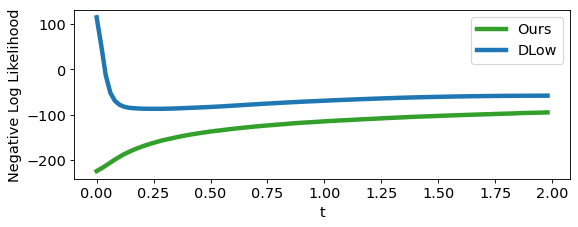

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 2.8), dpi=80)
plt.rcParams.update({'font.size': 13})
plt.plot(x, our_nll.numpy(), c='#33A02C', label='Ours', linewidth=4)
plt.plot(x, dlow_nll.numpy(), c='#1F78B4', label='DLow', linewidth=4)
plt.legend()
plt.gca().set_xlabel('t')
plt.gca().set_ylabel('Negative Log Likelihood')
plt.savefig('./nll.pdf', bbox_inches='tight', dpi=300)